이 스크립트는 왜 Full-batch로 Loss를 구하지 않고, 일부분의 데이터 셋으로 Loss를 구하더라도 충분히 학습이 가능한지 보여주는 것입니다. 

    즉 : Mini-batch SGD를 이용하는 논리적 근거를 보여주기 위함

In [2]:
%matplotlib inline
import os
import shutil
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt

np.random.seed(100)
tf.random.set_random_seed(100)

# Tensorboard의 Log파일이 저장될 위치
LOG_DIR = "./logs/"
if os.path.exists(LOG_DIR):
    shutil.rmtree(LOG_DIR)
os.makedirs(LOG_DIR,exist_ok=True)

## 데이터 셋

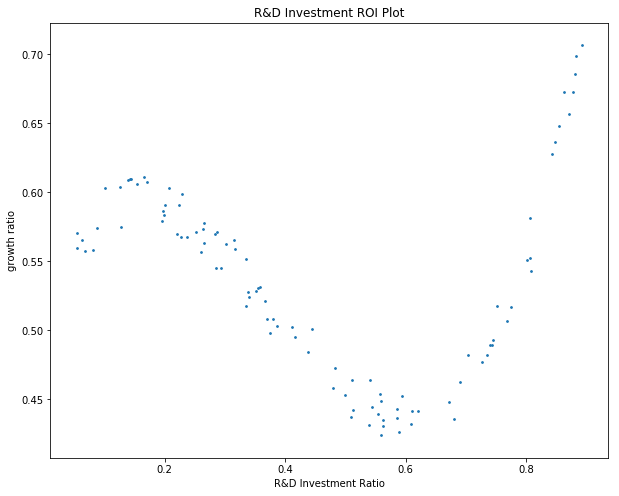

In [3]:
random_polynomial = lambda x : 3.5*x**3-4*x**2+x+0.5

invests = np.random.uniform(0.05,0.9, 100) # 20% ~ 80% 까지 기술 투자 비율
growths = np.array([random_polynomial(x)+np.random.uniform(0,0.04) 
           for x in invests]) # 예상 수익률

plt.figure(figsize=(10,8))
plt.scatter(invests, growths, s=3)
plt.title("R&D Investment ROI Plot")
plt.xlabel("R&D Investment Ratio")
plt.ylabel("growth ratio")
plt.show()

invests = invests.reshape(-1,1) # (data_nums, feature_nums) => (1000, 1)
growths = growths.reshape(-1,1) # (data_nums, target_nums) => (1000, 1)

# index를 생성하여, 순서를 섞음
idx = np.arange(len(invests))
np.random.shuffle(idx) 

# 학습 데이터셋 : 평가 데이터셋 = 7:3
train_nums = int(len(invests) * 0.7)
train_idx, test_idx = idx[:train_nums], idx[train_nums:]

# 데이터 셋 분리
train_invests, train_growths = invests[train_idx], growths[train_idx]
test_invests, test_growths = invests[test_idx], growths[test_idx]

## 이미 학습된 모델을 가져오자

In [ ]:
!wget https://s3.ap-northeast-2.amazonaws.com/pai-datasets/algorithm-ai-basic/lecture-3-sgd/model.ckpt.data-00000-of-00001
!wget https://s3.ap-northeast-2.amazonaws.com/pai-datasets/algorithm-ai-basic/lecture-3-sgd/model.ckpt.index
!wget https://s3.ap-northeast-2.amazonaws.com/pai-datasets/algorithm-ai-basic/lecture-3-sgd/model.ckpt.meta

INFO:tensorflow:Restoring parameters from ./model.ckpt
가져오는 variable : <tf.Variable 'hidden_1/kernel:0' shape=(1, 100) dtype=float32_ref>


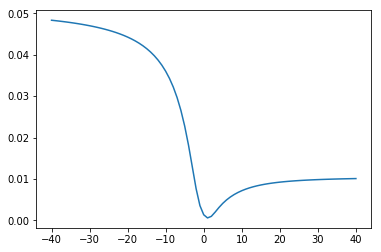

In [7]:
# Restore Model
graph = tf.Graph()
with graph.as_default():
    sess = tf.Session()
    saver = tf.train.import_meta_graph("./model.ckpt.meta")
    saver.restore(sess, "./model.ckpt")
    
    X = graph.get_tensor_by_name('X:0')
    y = graph.get_tensor_by_name('y:0')
    loss = graph.get_collection(tf.GraphKeys.LOSSES)[0]
    
    # Weight 하나 가져오기
    variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    variable = variables[0]    
    print("가져오는 variable :", variable)
    original_kernel = variable.eval(sess)

    # Weight에 -40~40까지 순차적으로 넣어 보자
    xs = np.linspace(-40,40,81)

    kernel = original_kernel.copy()
    ys = []
    for x in xs:
        # hiden
        kernel[0, 0] = x
        update_kernel = variable.assign(kernel)
        sess.run(update_kernel)

        result = sess.run(loss,feed_dict={X:train_invests,
                                          y:train_growths})

        ys.append(result)

    plt.plot(xs,ys)
    plt.show()

### 우린 Loss를 구하기 위해 늘 전체 데이터 셋을 써야 하나??

아니다. 꼭 전체 데이터셋을 쓸 필요 없이, 일부분만 써도 괜찮다

INFO:tensorflow:Restoring parameters from ./model.ckpt
가져오는 variable : <tf.Variable 'hidden_1/kernel:0' shape=(1, 100) dtype=float32_ref>


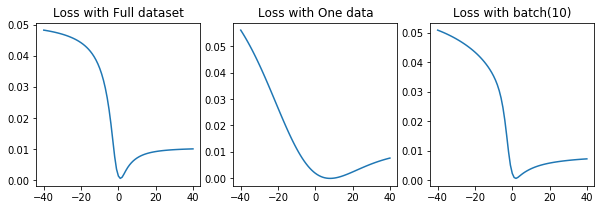

In [10]:
# Restore Model
graph = tf.Graph()
with graph.as_default():
    # 모델 불러오기
    sess = tf.Session()
    saver = tf.train.import_meta_graph("./model.ckpt.meta")
    saver.restore(sess, "./model.ckpt")
    
    X = graph.get_tensor_by_name('X:0')
    y = graph.get_tensor_by_name('y:0')
    loss = graph.get_collection(tf.GraphKeys.LOSSES)[0]
    
    # Weight 하나 가져오기
    variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    variable = variables[0]    
    original_kernel = variable.eval(sess)

    # Weight에 -10~10까지 바꿔가면서 넣어보자
    xs = np.linspace(-40,40,81)
    kernel = original_kernel.copy()

    ys_with_full = []
    ys_with_batch = []
    ys_with_one = []
    for x in xs:
        # hiden
        kernel[0,0] = x
        update_kernel = variable.assign(kernel)
        sess.run(update_kernel)

        loss_with_full = sess.run(loss,feed_dict={X:train_invests,
                                              y:train_growths})
        loss_with_batch = sess.run(loss,feed_dict={X:train_invests[0:10],
                                              y:train_growths[0:10]})
        loss_with_one = sess.run(loss,feed_dict={X:train_invests[0:1],
                                              y:train_growths[0:1]})
        ys_with_full.append(loss_with_full)
        ys_with_batch.append(loss_with_batch)
        ys_with_one.append(loss_with_one)

    fig = plt.figure(figsize=(10,3))
    ax = fig.add_subplot(1,3,1)
    ax.plot(xs,ys_with_full)
    ax.set_title("Loss with Full dataset")
    ax = fig.add_subplot(1,3,2)
    ax.plot(xs,ys_with_one)
    ax.set_title("Loss with One data")
    ax = fig.add_subplot(1,3,3)
    ax.plot(xs,ys_with_batch)
    ax.set_title("Loss with batch(10)")
    plt.show()

#### 배치 사이즈 별

INFO:tensorflow:Restoring parameters from ./model.ckpt


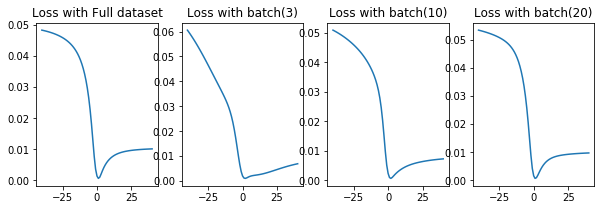

In [12]:
# Restore Model
graph = tf.Graph()
with graph.as_default():
    # 모델 불러오기
    sess = tf.Session()
    saver = tf.train.import_meta_graph("./model.ckpt.meta")
    saver.restore(sess, "./model.ckpt")
    
    X = graph.get_tensor_by_name('X:0')
    y = graph.get_tensor_by_name('y:0')
    loss = graph.get_collection(tf.GraphKeys.LOSSES)[0]
    
    # Weight 하나 가져오기
    variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    variable = variables[0]    
    original_kernel = variable.eval(sess)

    # Weight에 -10~10까지 바꿔가면서 넣어보자
    xs = np.linspace(-40,40,81)
    kernel = original_kernel.copy()

    ys_with_full = []
    ys_with_3 = []
    ys_with_10 = []
    ys_with_20 = []
    for x in xs:
        # hiden
        kernel[0,0] = x
        update_kernel = variable.assign(kernel)
        sess.run(update_kernel)

        loss_with_full = sess.run(loss,feed_dict={X:train_invests,
                                              y:train_growths})
        loss_with_3 = sess.run(loss,feed_dict={X:train_invests[0:3],
                                              y:train_growths[0:3]})
        loss_with_10 = sess.run(loss,feed_dict={X:train_invests[0:10],
                                              y:train_growths[0:10]})
        loss_with_20 = sess.run(loss,feed_dict={X:train_invests[0:20],
                                              y:train_growths[0:20]})

        
        ys_with_full.append(loss_with_full)
        ys_with_3.append(loss_with_3)
        ys_with_10.append(loss_with_10)
        ys_with_20.append(loss_with_20)

    fig = plt.figure(figsize=(10,3))
    ax = fig.add_subplot(1,4,1)
    ax.plot(xs,ys_with_full)
    ax.set_title("Loss with Full dataset")
    ax = fig.add_subplot(1,4,2)
    ax.plot(xs,ys_with_3)
    ax.set_title("Loss with batch(3)")
    ax = fig.add_subplot(1,4,3)
    ax.plot(xs,ys_with_10)
    ax.set_title("Loss with batch(10)")
    ax = fig.add_subplot(1,4,4)
    ax.plot(xs,ys_with_20)
    ax.set_title("Loss with batch(20)")
    plt.show()